In [1]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as gff
import seaborn as sns 

In [2]:
ticker = 'ESGU'
start = '2017-11-17'
end = '2022-11-01'

In [3]:
stock_data = yf.download(ticker, start, end, adjusted=True)
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-17,56.549999,56.584999,56.442001,56.509998,52.436539,3100
2017-11-20,56.660000,56.660000,56.509998,56.549999,52.473652,8600
2017-11-21,56.790001,56.910000,56.750000,56.900002,52.798424,5400
2017-11-22,56.900002,56.900002,56.834999,56.898998,52.797497,1900
2017-11-24,56.895000,57.000000,56.881001,57.000000,52.891224,3400


In [4]:
ff_monthly = gff.famaFrench3Factor(frequency='m')
ff_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
ff_monthly.set_index('Date', inplace=True)
ff_monthly.tail()

,Mkt-RF,SMB,HML,RF
Date,,,,
2022-05-31,-0.0034,-0.0185,0.0841,0.0003
2022-06-30,-0.0843,0.0209,-0.0597,0.0006
2022-07-31,0.0957,0.0281,-0.0410,0.0008
2022-08-31,-0.0378,0.0139,0.0031,0.0019
2022-09-30,-0.0936,-0.0081,0.0005,0.0019


In [5]:
stock_returns = stock_data['Adj Close'].resample('M').last().pct_change().dropna()
stock_returns.name = "Month_Rtn"
ff_data = ff_monthly.merge(stock_returns,on='Date')
ff_data.tail()

,Mkt-RF,SMB,HML,RF,Month_Rtn
Date,,,,,
2022-05-31,-0.0034,-0.0185,0.0841,0.0003,-0.000978
2022-06-30,-0.0843,0.0209,-0.0597,0.0006,-0.084496
2022-07-31,0.0957,0.0281,-0.0410,0.0008,0.095352
2022-08-31,-0.0378,0.0139,0.0031,0.0019,-0.040261
2022-09-30,-0.0936,-0.0081,0.0005,0.0019,-0.095308


In [6]:
X = ff_data[['Mkt-RF', 'SMB', 'HML']]
y = ff_data['Month_Rtn'] - ff_data['RF']
X = sm.add_constant(X)
ff_model = sm.OLS(y, X).fit()
print(ff_model.summary())
intercept, b1, b2, b3 = ff_model.params

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     4932.
Date:                Tue, 15 Nov 2022   Prob (F-statistic):           8.16e-66
Time:                        20:16:00   Log-Likelihood:                 250.24
No. Observations:                  58   AIC:                            -492.5
Df Residuals:                      54   BIC:                            -484.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.797      0.4

In [7]:
x_capm = ff_data[['Mkt-RF']]
y_capm = ff_data['Month_Rtn'] - ff_data['RF']
X_capm = sm.add_constant(x_capm)
ff_model_capm = sm.OLS(y_capm, X_capm).fit()
print(ff_model_capm.summary())
intercept_capm, b1_capm = ff_model_capm.params

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     7658.
Date:                Tue, 15 Nov 2022   Prob (F-statistic):           1.36e-61
Time:                        20:16:00   Log-Likelihood:                 230.19
No. Observations:                  58   AIC:                            -456.4
Df Residuals:                      56   BIC:                            -452.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.866      0.3

In [8]:
intercept_capm

0.000533052920155274

In [9]:
b1_capm

0.9774832433633753

In [10]:
mkt_rf = .61
hml = .38
smb = .25
rf = .33

In [11]:
capm_exreturn = rf + (mkt_rf*b1_capm)
(1+(capm_exreturn/100))**12-1

0.11699288513346806

In [12]:
ff_exreturn = rf + (mkt_rf*b1)+(smb*b2)+(hml*b3)
(1+(ff_exreturn/100))**12-1

0.11432919184466894

[Text(0.5, 1.0, 'ESGU')]

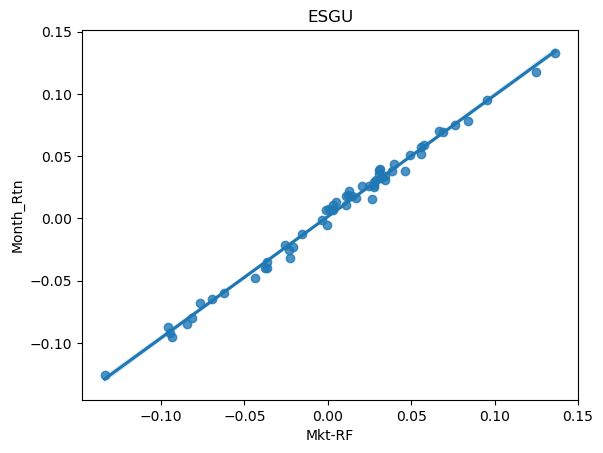

In [13]:
sns.regplot(data = ff_data, x = 'Mkt-RF', y='Month_Rtn').set(title = ticker )